In [1]:

import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from thbmodel.utils import timestamp, YEAR, settings, DAY
from thbmodel.utils.arrayview import ArrayView, TimeseriesView

from thbmodel.prediction.models.fit_model import TSModel
from thbmodel.prediction.models.model_parameters import ModelParameters
from thbmodel.prediction.models.factor_management import FactorList
from thbmodel.prediction.models.preprocessing import load_slices

from thbmodel.prediction.models.prediction import factornames_trimmed
from thbmodel.prediction.models.parameters import factor_build_end

In [2]:
av = ArrayView.from_file(settings.paths.join('racing_data_azd.av.bcolz'))
tsav = load_slices()

Original factors or simulated data

In [ ]:
simulated_data = False
if simulated_data:
    np.random.seed(10)
    random.seed(10)
    for i in range(len(factornames_trimmed)):
        del av[factornames_trimmed[i]]
        factornames_trimmed[i] = 'factor' + str(i)
        av[factornames_trimmed[i]] = np.random.normal(random.randint(1, 10), random.randint(1, 10), len(av.run_id))

Likelihood as a function of train data size and number of factors

In [3]:
def ll_function(tr_periods1 = 1, tr_periods2 = 365/14, n_factors1 = 1, n_factors2 = len(factornames_trimmed)):
    # tr_periods is the number of 14-day periods in is1, must not exceed 26
    max_tr_periods = 365 / 14
    
    # Likelihoods for the first pair of train period / number of factor arguments
    pars = ModelParameters(av, build_end=factor_build_end + (max_tr_periods - tr_periods1) * 14 * DAY, 
                            oos_start=factor_build_end + YEAR, depth=3, lmbd=10, 
                            verbose=True)
    fl = FactorList.from_av(av, factornames_trimmed[:n_factors1+1])
    fl.preprocess(pars)
    factors = fl.asmatrix()
    tsmod = TSModel(factors, tsav, pars)
    train_ll1, test_ll1 = tsmod.fit_factors_only()
    
    # Likelihoods for the second pair of train period / number of factor arguments
    pars = ModelParameters(av, build_end=factor_build_end + (max_tr_periods - tr_periods2) * 14 * DAY, 
                            oos_start=factor_build_end + YEAR, depth=3, lmbd=10, 
                            verbose=True)
    fl = FactorList.from_av(av, factornames_trimmed[:n_factors2+1])
    fl.preprocess(pars)
    factors = fl.asmatrix()
    tsmod = TSModel(factors, tsav, pars)
    train_ll2, test_ll2 = tsmod.fit_factors_only()
    
    return train_ll2 - train_ll1, test_ll2 - test_ll1

Example of using the function

In [12]:
per1, per2 = 10, 10
fac1, fac2 = 10, 20
trainll_gain, testll_gain = ll_function(per1, per2, fac1, fac2)
print ('Train log-likelihood changed by %.2f when number of train periods changed from %d to %d'
       ' and number of factors changed from %d to % d' % (trainll_gain, per1, per2, fac1, fac2))
print ('Test log-likelihood changed by %.2f when number of train periods changed from %d to %d'
       ' and number of factors changed from %d to % d' % (testll_gain, per1, per2, fac1, fac2))

INFO:models:Getting factors from av and rescaling...


.

INFO:models:Filling in missing values...


INFO:models:Computing each factor as linear combination of all the others...


 .

INFO:models:Number of missing patterns: 77


INFO:models:Getting factors from av and rescaling...


 .

INFO:models:Filling in missing values...


INFO:models:Computing each factor as linear combination of all the others...


 .

INFO:models:Number of missing patterns: 349


 Train log-likelihood changed by 4.65 when number of train periods changed from 10 to 10 and number of factors changed from 10 to  20
Test log-likelihood changed by 2.32 when number of train periods changed from 10 to 10 and number of factors changed from 10 to  20


Full simulation with plots

In [3]:
time_steps = range(25, -1, -1)
train_ll = np.zeros((len(time_steps), len(factornames_trimmed)))
test_ll = train_ll.copy()
for i in range(len(time_steps)):
    pars = ModelParameters(av, build_end=factor_build_end + time_steps[i] * 14 * DAY, oos_start=factor_build_end + YEAR, depth=3, lmbd=10, 
                           verbose=False)
    for j in range(len(factornames_trimmed)):
        fl = FactorList.from_av(av, factornames_trimmed[:j+1])
        fl.preprocess(pars)
        factors = fl.asmatrix()
        tsmod = TSModel(factors, tsav, pars)
        train_ll[i, j], test_ll[i, j] = tsmod.fit_factors_only()

Train error plot




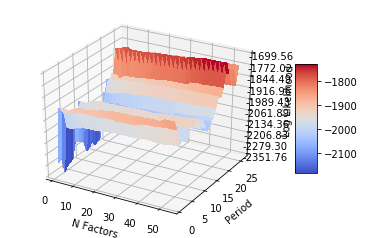

In [4]:
fig = plt.figure()
ax = fig.gca(projection='3d')
Y = np.arange(1, len(time_steps) + 1, 1)
X = np.arange(1,len(factornames_trimmed) + 1, 1)
X, Y = np.meshgrid(X, Y)
Z = train_ll
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('N Factors')
ax.set_ylabel('Period')
ax.set_zlabel('Log Likelihood')

plt.show()

Test error plot

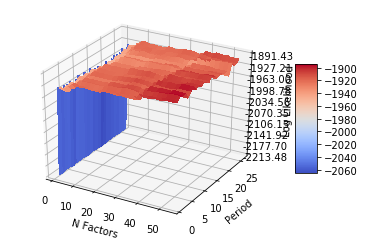

In [5]:
fig = plt.figure()
ax = fig.gca(projection='3d')
Y = np.arange(1, len(time_steps) + 1, 1)
X = np.arange(1,len(factornames_trimmed) + 1, 1)
X, Y = np.meshgrid(X, Y)
Z = test_ll
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('N Factors')
ax.set_ylabel('Period')
ax.set_zlabel('Log Likelihood')

plt.show()